In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import math
from matplotlib.pyplot import imsave
from matplotlib import pylab

from scipy.signal import find_peaks_cwt
%matplotlib inline

In [2]:
# #reading in an image
image = mpimg.imread('camera_cal/calibration1.jpg')
# # image = mpimg.imread('test_images/straight_lines1.jpg')
# #printing out some stats and plotting
# print('This image is:', type(image), 'with dimesions:', image.shape)
# plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

In [3]:
def save_images(image, path):
#     for img in images:
    image.save(path)
        
def plot_on_subplots(images, titles, cmap=None):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    
    if cmap:
        ax1.imshow(images[0], cmap=cmap)
    else:
        ax1.imshow(images[0])
    ax1.set_title(titles[0])

    if(cmap):
        ax2.imshow(images[1], cmap=cmap)
    else:
        ax2.imshow(images[1])
        
    ax2.set_title(titles[1])

## Compute the camera calibration matrix and distortion coefficients given a set of chessboard images

In [4]:
def getChessBoardPoints(path):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(path)

    # Step through the list and search for chessboard corners
    for fname in images:
    #     print(fname)
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
#             img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#             cv2.imshow('img',img)
#             cv2.waitKey(500)

#     cv2.destroyAllWindows()
    return objpoints, imgpoints

In [5]:
def getDistortionCoeff(image, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image.shape[0:2], None, None)
    return dist, mtx

def getUndistortedArray(images, dist, mtx):
    img_arr = []
    for img in images:
        img_arr.append(undistort(img, dist, mtx))
        
    return np.asarray(img_arr)

def undistort(img, dist, mtx):
    return cv2.undistort(img, mtx, dist, None, mtx)

def read_images(path):
    images = glob.glob(path)
    imges_array = []
    for img in images:
        img = cv2.imread(img);
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imges_array.append(img)
        
    return np.asarray(imges_array);

In [6]:
objpoints, imgpoints = getChessBoardPoints('./camera_cal/calibration*.jpg')

In [7]:
dist, mtx = getDistortionCoeff(image, objpoints, imgpoints)

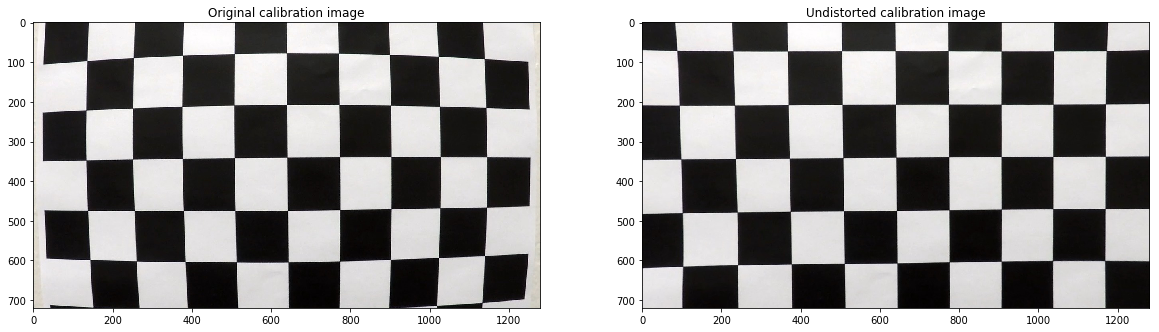

In [14]:
raw_images = read_images('./test_images/*')
image_to_test = raw_images[2]
undistorted_chess = undistort(image, dist, mtx)
plot_on_subplots([image, undistorted_chess], ['Original calibration image', 'Undistorted calibration image'])
pylab.savefig("./output_images/calibrated.png")

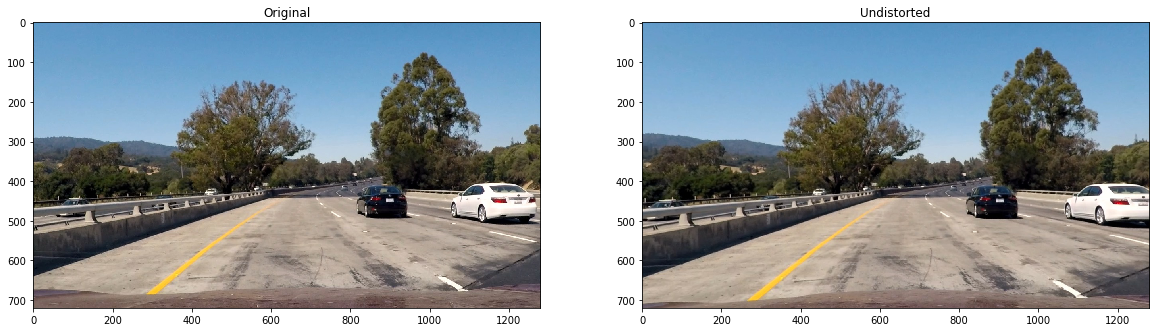

In [15]:
plot_on_subplots([image_to_test, undistort(image_to_test, dist, mtx)], ['Original', 'Undistorted'])
pylab.savefig("./output_images/input_images.png")

# Compute thresholds

In [16]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
        
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def color_thresh(img, thresh=(0, 255)):
    binary = np.zeros_like(img)
    binary[(img >= thresh[0]) & (img <= thresh[1])] = 1
    return binary;


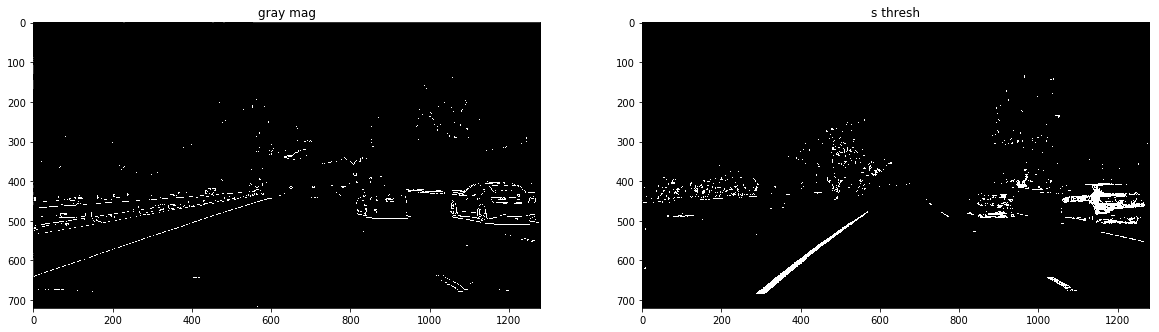

In [17]:
def get_thresholded_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    gray_mag_thresh = mag_thresh(gray, 3, (90, 180))
    hls_s_thresh = color_thresh(hls[:,:,2], (180, 255))
    dir_thresh = dir_threshold(gray, 3, (1.5, np.pi/2))
    
    sobelx = abs_sobel_thresh(gray, 'x', 3, (20, 200))
    hls_l_thresh = color_thresh(hls[:,:,1], (200, 255))
#     color_binary = np.dstack(( np.zeros_like(gray_mag_thresh), gray_mag_thresh, hls_s_thresh))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(gray_mag_thresh)
    combined_binary[(hls_s_thresh == 1) | (gray_mag_thresh == 1) | (hls_s_thresh == 1) | (sobelx == 1)] = 1
    return combined_binary

gray = cv2.cvtColor(image_to_test, cv2.COLOR_RGB2GRAY)
hls = cv2.cvtColor(image_to_test, cv2.COLOR_RGB2HLS)

gray_mag_thresh = mag_thresh(gray, 3, (90, 180))
hls_s_thresh = color_thresh(hls[:,:,2], (180, 255))

plot_on_subplots([gray_mag_thresh, hls_s_thresh], ["gray mag", "s thresh"], cmap='gray')
pylab.savefig("./output_images/mag_hls_s.png")

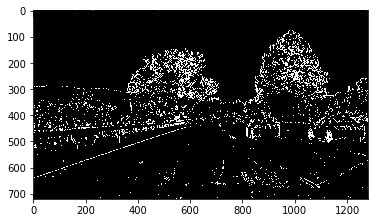

In [18]:
sobelx = abs_sobel_thresh(gray, 'x', 3, (20, 200))
plt.imshow(sobelx, cmap='gray')
imsave("./output_images/sobelx.png", sobelx, cmap="gray")

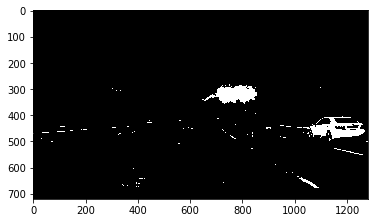

In [19]:
hls_l_thresh = color_thresh(hls[:,:,1], (200, 255))
plt.imshow(hls_l_thresh, cmap='gray')
imsave("./output_images/hls_l_thresh.png", hls_l_thresh, cmap="gray")

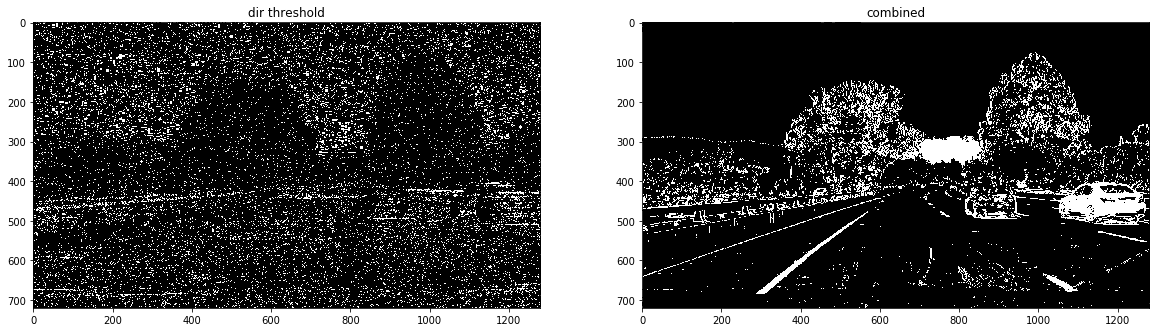

In [20]:
dir_thresh = dir_threshold(gray, 3, (1.5, np.pi/2))


# color_binary = np.dstack(( np.zeros_like(gray_mag_thresh), gray_mag_thresh, hls_s_thresh))

# Combine the two binary thresholds
combined_binary = np.zeros_like(gray_mag_thresh)
combined_binary[(hls_s_thresh == 1) | (gray_mag_thresh == 1) | (sobelx == 1) | (hls_l_thresh == 1)] = 1
plot_on_subplots([dir_thresh, combined_binary], ["dir threshold", "combined"], cmap='gray')
imsave("./output_images/dir_thresh.png", dir_thresh, cmap="gray")
imsave("./output_images/combined_binary.png", combined_binary, cmap="gray")

# Hough lines

In [21]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    
#     for line in lines:
#         for x1,y1,x2,y2 in line:
#             cv2.line(img, (x1, y1), (x2, y2), [0, 255, 0], 5)
    
    right_lines = []
    left_lines = []
    y_max = image.shape[0]
    y_min = image.shape[0]
    for line in lines:
        for x1, y1, x2, y2 in line:
            if y1 < y_min:
                y_min = y1
                
            if y2 < y_min:
                y_min = y2
    y_min = image.shape[0] * 0.7        
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2-y1)/(x2-x1)
            if slope > 0.0 and slope < np.inf:
                right_lines.append(line)
            elif slope < 0.0 and slope > -np.inf:
                left_lines.append(line)
                
    left_line_avg = np.mean(left_lines, axis=0)
    right_line_avg = np.mean(right_lines, axis=0)
#     print(left_line_avg)
#     print(left_line_avg[0][3])
    slope_left = (left_line_avg[0][3] - left_line_avg[0][1])/(left_line_avg[0][2] - left_line_avg[0][0])
    slope_right = (right_line_avg[0][3] - right_line_avg[0][1])/(right_line_avg[0][2] - right_line_avg[0][0])
    
    new_x1_left = left_line_avg[0][0] - (left_line_avg[0][1] - y_min)/slope_left
    new_x2_left = left_line_avg[0][2] + (y_max - left_line_avg[0][3])/slope_left
    
    new_x1_right = right_line_avg[0][0] - (right_line_avg[0][1] - y_min)/slope_right
    new_x2_right = right_line_avg[0][2] + (y_max - right_line_avg[0][3])/slope_right
    
    
    line1 = (int(new_x1_left), y_min, int(new_x2_left), y_max)
    line2 = (int(new_x1_right), y_min, int(new_x2_right), y_max)
    cv2.line(img, (int(new_x1_left), int(y_min)), (int(new_x2_left), y_max), color, 5)
    cv2.line(img, (int(new_x1_right), int(y_min)), (int(new_x2_right), y_max), color, 5)
    
    return (line1, line2)


def get_single_line(lines, y_min, y_max):

    points = []
    total_slope = 0
    total_y_intercept = 0
    n = len(lines)
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2 - y1)/(x2 - x1)
            total_slope += slope
            total_y_intercept += (y1 - slope * x1)
    
    average_slope = total_slope/n
    average_y_intercept = total_y_intercept/n
    
    x1 = int((y_min - average_y_intercept)/average_slope)
    x2 = int((y_max - average_y_intercept)/average_slope)
    
    return (x1, y_min,x2, y_max)

def draw_lines2(img, lines, color=[255, 0, 0], thickness=5):
    
    y_min = int(img.shape[0] * 0.7) 
    y_max = img.shape[0]

    right_lines = []
    left_lines = []
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2-y1)/(x2-x1)
            if slope > 0.5 and slope < 0.9:
                left_lines.append(line)
            elif slope < -0.5 and slope > -0.9:
                right_lines.append(line)
    
    line1 = None
    line2 = None
    # to avoid div by 0
    if(len(left_lines) > 0):
        line1 = get_single_line(left_lines, y_min, y_max)
        cv2.line(img, (line1[0], line1[1]), (line1[2], line1[3]), color, thickness)

    if(len(right_lines) > 0):
        line2 = get_single_line(right_lines, y_min, y_max)
        cv2.line(img, (line2[0], line2[1]), (line2[2], line2[3]), color, thickness)
    
    if line2 == None or line2 == None:
        return None
    
    return (line1, line2)

    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
#     print(lines)
#     line_img = np.zeros(img.shape, dtype=np.uint8)
#     plt.imshow(lines)
    lines = draw_lines2(line_img, lines)
#     plt.imshow(line_img)
    return lines, line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def get_blank_image(image):
    """
        Return a blank image with the same dimensions as
        the input image
    """
    return np.zeros(image.shape, dtype=np.uint8)

/Users/knock/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:118: RuntimeWarning: divide by zero encountered in int_scalars


((774, 503, 1120, 720), (522, 503, 224, 720))


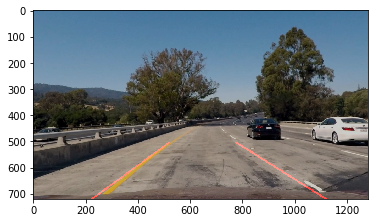

In [22]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
#     img_gray = grayscale(image)
    blur_gray = gaussian_blur(image, 5)
#     edges = canny(blur_gray, 50, 150)
    imshape = image.shape
    
    bottom_left = (image.shape[1] * 0.15, image.shape[0])
    bottom_right = (image.shape[1] * 0.93, image.shape[0])

    top_left = (image.shape[1] * 0.4 , image.shape[0]/2)
    top_right = (image.shape[1] * 0.6 , image.shape[0]/2)
#     print(bottom_left, bottom_right, top_left, top_right)
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
#     vertices = np.array([[(0,imshape[0]),(560, 410), (630, 410), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(blur_gray, vertices)
    lines, line_img = hough_lines(masked_edges, 1, np.pi/180, 30, min_line_len=1, max_line_gap=5)
#     print(lines.shape)
#     colored_lines_image = np.dstack((lines, get_blank_image(lines), get_blank_image(lines)))
#     plt.imshow(lines)
#     print(lines.shape)
#     print(image.shape)
#     plt.imshow(image, cmap='gray')
#     image = np.dstack((image, np.zeros(image.shape), np.zeros(image.shape)))
#     result = weighted_img(lines, image)
    return lines, line_img

lines, lines_img = process_image(combined_binary)
print(lines)
undistorted_image = undistort(image_to_test, dist, mtx)
final_image = weighted_img(lines_img, undistorted_image)
plt.imshow(final_image)
imsave("./output_images/hough_lines.png", final_image)

# Transformation matrix and warping

In [23]:
def getPerspectiveTransformMatrx(lines, undistorted_image):
    
#     print(lines)
    if lines == None:
        return undistorted_image, undistorted_image
    line1 = lines[0]
    line2 = lines[1]
#     print(line1[0])
#     print(line2)
    offset = undistorted_image.shape[0] * 0.3
    # bottom left, top left, top right, bottom right
    src = np.float32([[line1[2], line1[3]], [line1[0], line1[1]], [line2[0], line2[1]], [line2[2], line2[3]]]);
    dst = np.float32([[line1[2], line1[3]], [line1[2], offset], [line2[2], offset], [line2[2], line2[3]]]);
#     print(src)
#     print(dst)
    
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    
    return M, Minv

def getWarpedImage(img, matrix):
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, matrix, img_size, flags=cv2.INTER_LINEAR)
    return warped


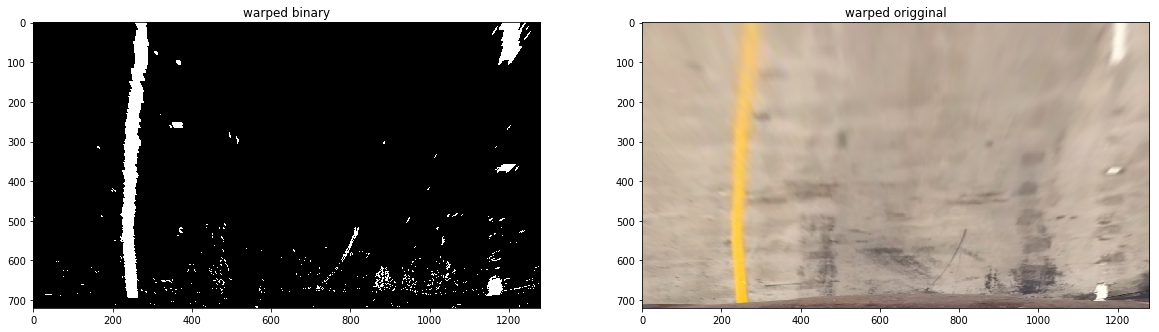

In [25]:
M, Minv = getPerspectiveTransformMatrx(lines, undistorted_image)
warped_image = getWarpedImage(combined_binary, M)
warped_image_input = getWarpedImage(undistorted_image, M)
plot_on_subplots([warped_image, warped_image_input], ["warped binary", "warped origginal"], cmap='gray')
pylab.savefig("./output_images/warped.png")

/Users/knock/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


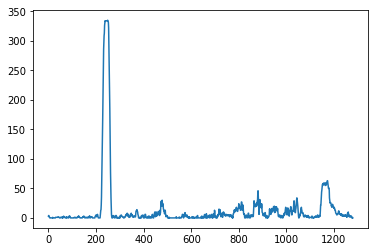

In [26]:
histogram = np.sum(warped_image[warped_image.shape[0]/2:,:], axis=0)
plt.plot(histogram)
pylab.savefig("histogram.png")
# imsave("./output_images/histogram.png", histogram)

In [27]:
def get_lines_base(image):
    histogram = np.sum(image[image.shape[0]/2:,:], axis=0)
    indexes = find_peaks_cwt(histogram, np.arange(1, 550))
    return [(indexes[0], image.shape[0]), (indexes[-1], image.shape[0])]

In [28]:
line_base = get_lines_base(warped_image)

/Users/knock/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


In [29]:
print(line_base)

[(246, 720), (1160, 720)]


# Finding pixels and fitting polynomial

In [30]:
def get_lane_pixels(image, lane_base):
    window_size = 100
    x_base = lane_base[0]
    X_avg = x_base
    y_bottom = image.shape[0]
    y_top = y_bottom - window_size
    print(y_bottom)
    print(y_top)
    x, y  = [], []
    win_left = x_base - window_size/2
    win_right = x_base + window_size/2
    last = False
    
    win_bottom = y_bottom
    win_top = y_top
    
    while True:
        
        diff = 0.0
        if X_avg != x_base:
            diff = x_base - X_avg
            print(diff)
            x_base = X_avg
         
        print("win_left: " + str(win_left))
        print("win_right: " + str(win_right))
        
        win_left = win_left - diff
        win_right = win_right - diff
        
        print("win_left: " + str(win_left))
        print("win_right: " + str(win_right))
        
        if win_left < 0:
            win_left == 0

        if win_left > image.shape[1] or win_right < 0:
            break;
            
        if win_right > image.shape[1]:
            win_right = image.shape[1]

            
        window = image[int(win_top):int(win_bottom), int(win_left):int(win_right)]
        plt.imshow(window)
#         break;
#         print(window)
        print(window.shape)
        xw, yw = np.where(window == 1)
        print(xw)
        X_avg = np.average(xw) + win_left
        print("X_Avg: " + str(X_avg))
        x.append(xw)
        y.append(yw)
        
        print("last: " + str(last))
        if last:
            break;
            
        win_bottom -= window_size
        win_top -= window_size
        
        print("Win_top: "  + str(win_top))
        if win_top < 0:
            win_top = 0
            last = True
    
    
    return x, y

def get_lane_pixels2(image, lane_base):
    window_size = 150 * 2
    
    x_base = lane_base[0]
    
    if(x_base > window_size):
        window_low = x_base - window_size/2
    else:
        window_low = 0
        
    window_high = x_base + window_size/2
    
#     plt.imshow(image)
    window = image[:, window_low:window_high]
#     plt.imshow(window)
    y, x = np.where(window == 1)
    
#     print(window_low)
    x += np.uint64(window_low)
    
    return (x, y)

In [31]:
left_line, right_line = line_base
# plt.imshow(warped_image)
left_pixels = get_lane_pixels2(warped_image, left_line)
right_pixels = get_lane_pixels2(warped_image, right_line)
print(right_pixels)

(array([1183, 1184, 1185, ..., 1061, 1062, 1101]), array([  0,   0,   0, ..., 719, 719, 719]))


/Users/knock/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:84: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [32]:
def get_curved_poly(y, x, degree=2):
    line_fit = np.polyfit(y, x, degree)
    line_fitx = line_fit[0]*y**2 + line_fit[1]*y + line_fit[2]
    return (line_fit, line_fitx)

In [33]:
def plot_curved_line(left_pixels, right_pixels, left_line, right_line):

    mark_size = 3
    plt.xlim(0, 1280)
    plt.ylim(0, 720)
    plt.plot(left_pixels[0], left_pixels[1], 'o', color='red', markersize=mark_size)
    plt.plot(right_pixels[0], right_pixels[1], 'o', color='blue', markersize=mark_size)
    plt.plot(left_line, left_pixels[1], color='green', linewidth=3)
    plt.plot(right_line, right_pixels[1],color='green', linewidth=3)
#     plt.plot(left_line, y_left, color='green', linewidth=3)
#     plt.plot(right_line, y_right, color='green', linewidth=3)
    plt.gca().invert_yaxis() 
    pylab.savefig("./output_images/curved_lines.png")

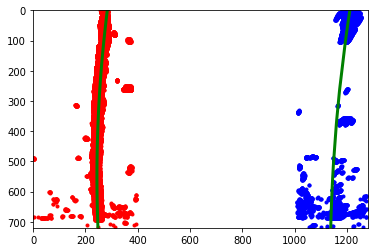

In [34]:
left_line_curve = get_curved_poly(left_pixels[1], left_pixels[0], 2)
right_line_curve = get_curved_poly(right_pixels[1], right_pixels[0], 2)
plot_curved_line(left_pixels, right_pixels, left_line_curve[1], right_line_curve[1])
# draw_curved_line(warped_image, left_line_curve[0])



In [ ]:
# print(left_line_curve[0])

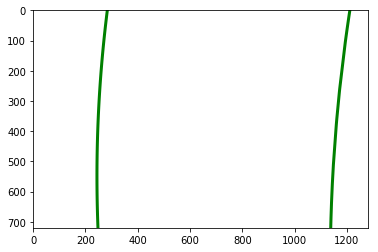

In [35]:
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_line_curve[1], left_pixels[1], color='green', linewidth=3)
plt.plot(right_line_curve[1], right_pixels[1],color='green', linewidth=3)
plt.gca().invert_yaxis()

y_max_l = np.max(left_pixels[1])
line_fitx_l = left_line_curve[0][0]*y_max_l**2 + left_line_curve[0][1]*y_max_l + left_line_curve[0][2]
#     print(line_fitx)

y_max_r = np.max(right_pixels[1])
line_fitx_r = right_line_curve[0][0]*y_max_r**2 + right_line_curve[0][1]*y_max_r + right_line_curve[0][2]
#     print(line_fitx_r)

lane_center = (line_fitx_l + line_fitx_r)/2
actual_center = image.shape[1]/2

diff = lane_center - actual_center
diff = diff*3.7/700
center_txt = None
if(diff > 0):
    # right
    center_txt = "Vehicle is " + str(round(diff, 2)) + "m right of center"
else:
    # left
    center_txt = "Vehicle is " + str(round(-1*diff, 2)) + "m left of center"

In [36]:
def calculate_rad_curvature(left_fit, right_fit, left_pixels, right_pixels):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    y_eval_left = np.max(left_pixels[1])
    y_eval_right = np.max(right_pixels[1])
    
#     print(y_eval_right)
    
    fit_left = np.polyfit(left_pixels[1]*ym_per_pix, left_pixels[0]*xm_per_pix, 2)
    fit_right = np.polyfit(right_pixels[1]*ym_per_pix, right_pixels[0]*xm_per_pix, 2)
    
    left_curverad = ((1 + (2*fit_left[0]*y_eval_left*ym_per_pix + fit_left[1])**2)**1.5) / np.absolute(2*fit_left[0])
    right_curverad = ((1 + (2*fit_right[0]*y_eval_right*ym_per_pix + fit_right[1])**2)**1.5) / np.absolute(2*fit_right[0])
    
#     print(left_curverad, right_curverad)
    return left_curverad, right_curverad

In [37]:
left_curverad, right_curverad = calculate_rad_curvature(left_line_curve[0], right_line_curve[0], left_pixels, right_pixels)
print(left_curverad, right_curverad)

1250.77197507 1589.78334823


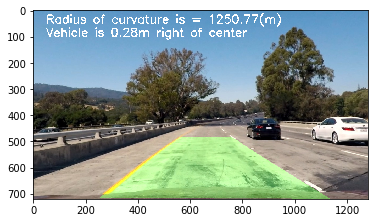

In [38]:
def final_transform(warped_image, undist_image, left_pixels, right_pixels, left_line_curve, right_line_curve, Minv):
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_line_curve[1], left_pixels[1]]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line_curve[1], right_pixels[1]])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_image, 1, newwarp, 0.3, 0)
    return result;




warp_zero = np.zeros_like(warped_image).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_line_curve[1], left_pixels[1]]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line_curve[1], right_pixels[1]])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undistorted_image, 1, newwarp, 0.3, 0)
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(result, 'Radius of curvature is = ' + str(round(left_curverad, 2)) + "(m)", (50,50), font, 1.5,(255,255,255), 3)
cv2.putText(result, center_txt, (50,100), font, 1.5,(255,255,255), 3)
plt.imshow(result)
imsave("./output_images/result.png", result)

In [39]:
def process_image_advanced(image):
    
    # undistorted
    undist = undistort(image, dist, mtx)
    
    # thresholded binary
    combined_binary = get_thresholded_image(undist)
    
    # hough lines
    lines, lines_img = process_image(combined_binary)
#     final_image = weighted_img(lines_img, undist)
#     plt.imshow(final_image)
    
    # perspective transform
#     M, Minv = getPerspectiveTransformMatrx(lines, undist)
    warped_image = getWarpedImage(combined_binary, M)
    
    # get left and right lines pixels
    line_base = get_lines_base(warped_image)
    left_line, right_line = line_base
    left_pixels = get_lane_pixels2(warped_image, left_line)
    right_pixels = get_lane_pixels2(warped_image, right_line)
    
    # fit left right pixels to a order 2 polynomial
    left_line_curve = get_curved_poly(left_pixels[1], left_pixels[0], 2)
    right_line_curve = get_curved_poly(right_pixels[1], right_pixels[0], 2)
    
    y_max_l = np.max(left_pixels[1])
    line_fitx_l = left_line_curve[0][0]*y_max_l**2 + left_line_curve[0][1]*y_max_l + left_line_curve[0][2]
#     print(line_fitx)

    y_max_r = np.max(right_pixels[1])
    line_fitx_r = right_line_curve[0][0]*y_max_r**2 + right_line_curve[0][1]*y_max_r + right_line_curve[0][2]
#     print(line_fitx_r)
    
    lane_center = (line_fitx_l + line_fitx_r)/2
    actual_center = image.shape[1]/2
    
    diff = lane_center - actual_center
    diff = diff*3.7/700
    center_txt = None
    if(diff > 0):
        # right
        center_txt = "Vehicle is " + str(round(diff, 2)) + "m right of center"
    else:
        # left
        center_txt = "Vehicle is " + str(round(-1*diff, 2)) + "m left of center"
    # get left and right radius of the curvature in meters
    left_curverad, right_curverad = calculate_rad_curvature(left_line_curve[0], right_line_curve[0], left_pixels, right_pixels)
    
    # final transformation back to original image
    final_image = final_transform(warped_image, undist, left_pixels, right_pixels, left_line_curve, right_line_curve, Minv)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(final_image, 'Radius of curvature is = ' + str(round(left_curverad, 2)) + "(m)", (50,50), font, 1.5,(255,255,255), 3)
    cv2.putText(final_image, center_txt, (50,100), font, 1.5,(255,255,255), 3)
    return final_image

/Users/knock/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:118: RuntimeWarning: divide by zero encountered in int_scalars
/Users/knock/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app
/Users/knock/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:84: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


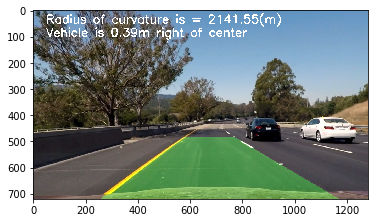

In [40]:
final_image = process_image_advanced(raw_images[7])
plt.imshow(final_image)

In [ ]:

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
white_output = 'challenge_video_out.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image_advanced) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))